<a href="https://www.kaggle.com/code/ayushs9020/understanding-the-competition-go-daddy-eda?scriptVersionId=130101044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# GoDaddy - Microbusiness Density Forecasting

The `goal` of the competition is to `help policymakers gain visibility into microbusinesses`, a growing trend of very small entities. `Additional information` will enable new policies and programs to `improve the success and impact of these smallest of businesses`. The competition dataset consists of `historical data on microbusinesses in the United States`. The data includes information on the `number of microbusinesses`, `the type of microbusiness`, the `location of the microbusiness`, and the `age of the microbusiness`.  The competition is divided into two phases
* `training phase` - participants can use the historical data to train their models
* `forecasting phase` - participants submit their predictions for the future density of microbusinesses

<img src = "https://www.meme-arsenal.com/memes/190b2f3ce95e0bd3624049fd6314c3cd.jpg">

# 1 | About The Data 🚀

We are given a `basic regression` probelem where the target column is `microbusiness_density` , which is to be predicted. This target column shows the `density of microbusiness` at a particular area, at a particular time period `(usually more than a day in frquency)`. We will predict this value on the basis of `some information about that area/locality at that particular time` collected from `census`. We are not just given a `training file` and a `testing file`, rather a mixture

## Training File 

Though you can train a model on just the `train.csv` file, and even test it on the `test.csv`. But a lot more inforamtion is given in the `census_starter.csv`

|____|____|
|---|---
|`row_id`|Not actually unique for every column, but rather contains the information about the time period|
||Though you can find that information particularly in another column|
|`cfips` |The first $2$ digits correspond to the state `FIPS code`, while the following 3 represent the county.
|`country`|Name of the country
|`state`|Name of the State
|`first_day_of_month`|Time period of the collected sample|
|`microbusiness_density`|The major target column
|`active`| The raw count of microbusinesses in the county

## Starter Census File 
This file contians the additional information about the loaclity. The data is taken from the `Census Tables`. It contains the data of past $4$ for more accurate analysis of the current situation. 

For convinence I chose to wirte `[year]` instead of defining the same thing for different years, like done by `GoDaddy`

|____|____|
|---|---
|`pct_bb_[year]`|The percentage of households in the county with access to broadband of any type
|`pct_college_[year]`|The percent of the population in the county over age 25 with a 4-year college degree
|`pct_foreign_born_[year]`|The percent of the population in the county born outside of the United States
|`pct_it_workers_[year]`| The percent of the workforce in the county employed in information related industries
|`median_hh_inc_[year]`|The median household income in the county

# 2 | Advisory Points to Note 📝

* Combine the `train,test` and the `census_starter` files, while retaining the `cfips` as the foriegn key for the connection

## TRAIN 
* `pct_bb` - data is skewed towards left, recomnd using `sklearn.preprocssing.FunctionTrnasformer`
* `pct_college` - data is similar for the $5$ years, can be combined for reducing training time
* `pct_foreign_born` - data is highly similar for the $5$ years, can be combined for reducing training time
* `pct_it_workers` - data is in good form
* `median_hh_inc` - highly valuable data

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


Now lets get started working with the data 

In [5]:
train = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


This is our `training data` containing $1,22,265$ rows and $7$ columns accounting to $8,55,555$ values

In [6]:
census = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.2,82.4,84.0,86.7,88.4,56037,15.3,15.2,14.8,13.7,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
3138,83.5,85.9,87.1,89.1,90.5,56039,37.7,37.8,38.9,37.2,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,...,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0


This is our `census_starter` with $3142$ rows and $26$ columns accounting to a total of $81,692$

For making a perfect data for `training and testing`, we first need to combine both of these datasets into $1$. We can do this just by simply running a nested `for loop`. FOr this instance, we will only perform the action for `training data`

In [7]:
for i in census.columns.delete(5):
    train[i] = pd.DataFrame([x for x in range(train.shape[0])])

In [8]:
for index , country_code in enumerate(census["cfips"].unique()):
    for column in census.columns.delete(5):
        train[column] = np.where(train["cfips"] == country_code , census[column][index] , train[column])

In [9]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,pct_bb_2017,pct_bb_2018,pct_bb_2019,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0


And now we have changed our whole dataset perfectly. Now it has $1,22,265$ rows and $32$ columns accounting to $39,12,480$ values

Now lets drop some useless columns 

In [10]:
train.drop(["row_id" , "cfips"] , axis = 1 , inplace = True)

Though we will try to analyse the data thorugh the `census_starter` file, because for the `train` file, the files have basically became distint classes, and thus will show flat planes in the graphs at many points. 

But first we will convert the `first_day_of_month` into a accessible format.

In [11]:
train[["Year" , "Month" , "Date"]] = train["first_day_of_month"].str.split("-" , expand = True)

train["Year"] = train["Year"].astype(int)
train["Moonth"] = train["Month"].astype(int)
train["Date"] = train["Date"].astype(int)

train.drop("first_day_of_month" , axis = 1 , inplace = True)

In [12]:
train

,county,state,microbusiness_density,active,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,...,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,Year,Month,Date,Moonth
0,Autauga County,Alabama,3.007682,1249,76.6,78.9,80.6,82.7,85.5,14.5,...,1.1,55317,58786.0,58731,57982.0,62660.0,2019,08,1,8
1,Autauga County,Alabama,2.884870,1198,76.6,78.9,80.6,82.7,85.5,14.5,...,1.1,55317,58786.0,58731,57982.0,62660.0,2019,09,1,9
2,Autauga County,Alabama,3.055843,1269,76.6,78.9,80.6,82.7,85.5,14.5,...,1.1,55317,58786.0,58731,57982.0,62660.0,2019,10,1,10
3,Autauga County,Alabama,2.993233,1243,76.6,78.9,80.6,82.7,85.5,14.5,...,1.1,55317,58786.0,58731,57982.0,62660.0,2019,11,1,11
4,Autauga County,Alabama,2.993233,1243,76.6,78.9,80.6,82.7,85.5,14.5,...,1.1,55317,58786.0,58731,57982.0,62660.0,2019,12,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,Weston County,Wyoming,1.803249,101,71.1,73.3,76.8,79.7,81.3,14.1,...,0.0,59605,52867.0,57031,53333.0,65566.0,2022,06,1,6
122261,Weston County,Wyoming,1.803249,101,71.1,73.3,76.8,79.7,81.3,14.1,...,0.0,59605,52867.0,57031,53333.0,65566.0,2022,07,1,7
122262,Weston County,Wyoming,1.785395,100,71.1,73.3,76.8,79.7,81.3,14.1,...,0.0,59605,52867.0,57031,53333.0,65566.0,2022,08,1,8
122263,Weston County,Wyoming,1.785395,100,71.1,73.3,76.8,79.7,81.3,14.1,...,0.0,59605,52867.0,57031,53333.0,65566.0,2022,09,1,9


# 3 | Data Analysis 📈

## PCT BB 

Broadband internet access has a positive impact on microbusiness density. Broadband access allows microbusinesses to connect with customers and suppliers, access information and resources, and collaborate with other businesses. This can help microbusinesses to grow and succeed.

If we normalyy see the graph, it is very much crowded.

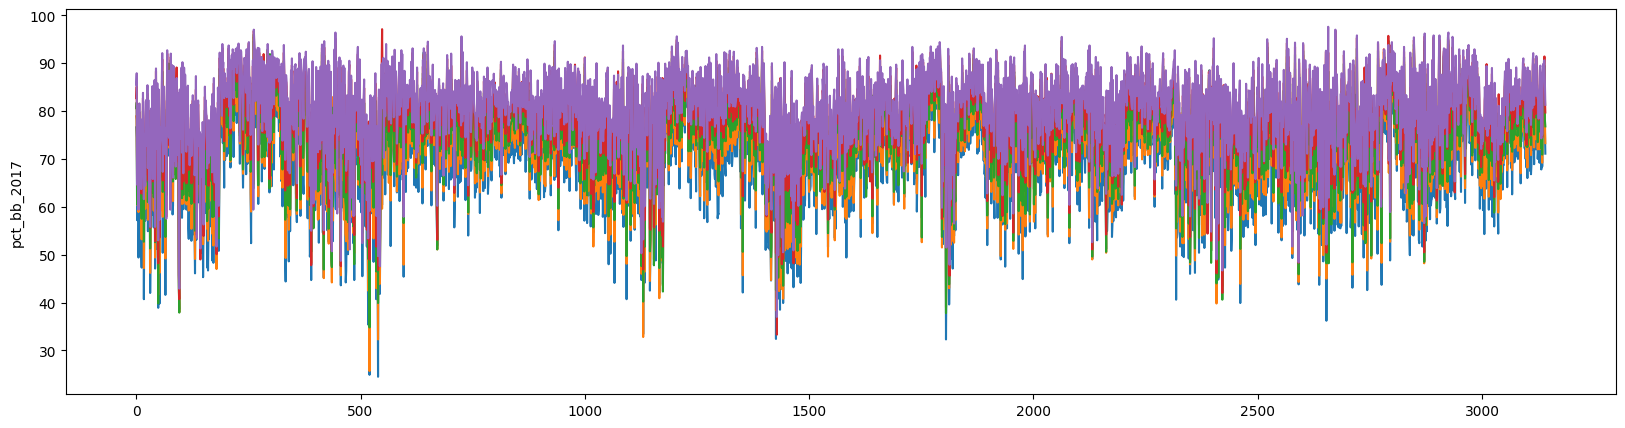

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in ["pct_bb_2017" , "pct_bb_2018" , "pct_bb_2019" , "pct_bb_2020" , "pct_bb_2021"]:
    sns.lineplot(census[i] , ax = ax)
    

Thus we make strides of window size $20$, giving it a cleaner representation and also retaining the core intution behind the data

In [14]:
x = np.empty(157)
y = np.empty((5 , 157))
for l , j in enumerate(["pct_bb_2017" , "pct_bb_2018" , "pct_bb_2019" , "pct_bb_2020" , "pct_bb_2021"]):
    for i , k  in enumerate(torch.as_strided(torch.tensor(census[j][:3140])  , (157,20) , (20 ,1))):
        x[i] = torch.mean(k)
    y[l] = x

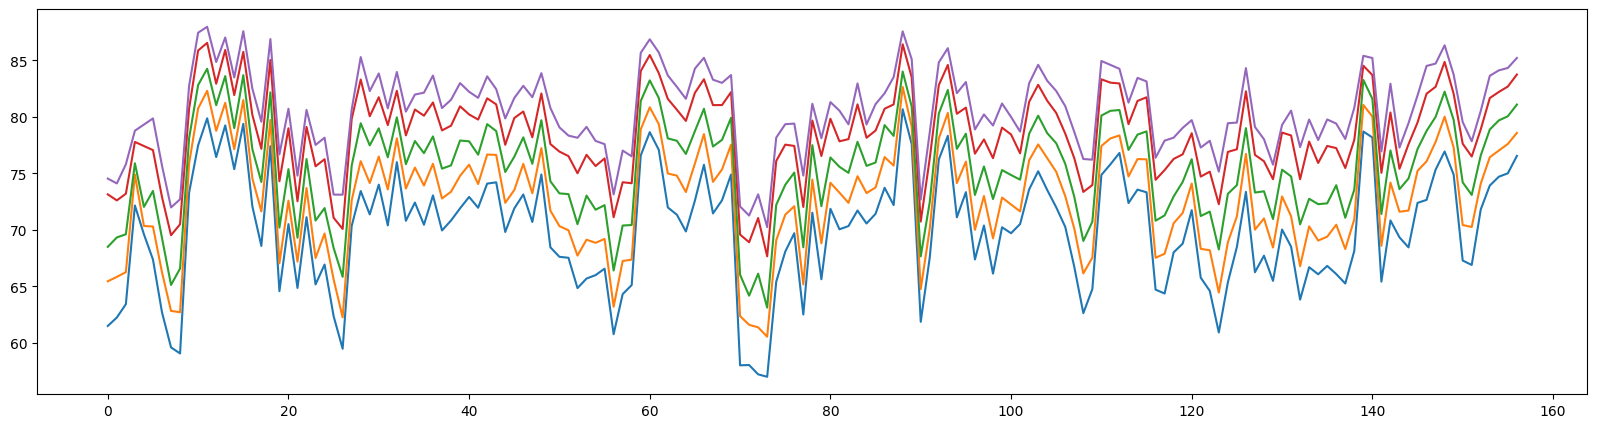

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in range(5):
    sns.lineplot(y[i] , ax = ax)
    

As we can see that the data increase and decrease lineaerly with time period. 

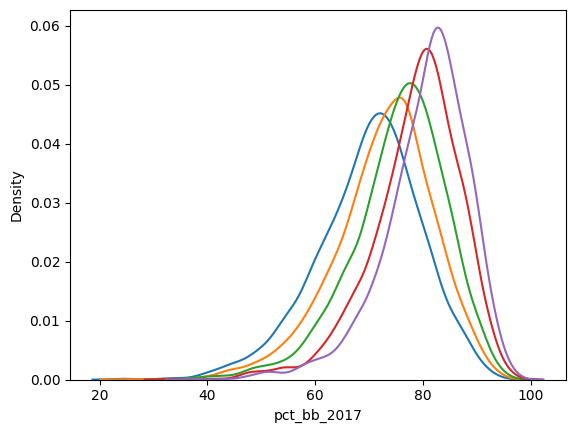

In [16]:
for i in ["pct_bb_2017" , "pct_bb_2018" , "pct_bb_2019" , "pct_bb_2020" , "pct_bb_2021"]:
    sns.kdeplot(census[i])

Though the values are a little shifted towards the right or sweeped towards the left. We might need to apply `FunctionTransformers` here 

## Pct College

There is a positive correlation between the percent of the population in a county over age $25$ with a $4-year$ college degree and the microbusiness density of the county. This means that counties with a higher percentage of college-educated residents tend to have more microbusinesses.

There are a few reasons for this correlation.
* Entrepreneurial - They are more likely to have the skills and knowledge necessary to start their own businesses.
* Eccess to capital. - They are more likely to have savings or be able to get loans from banks.
* Connected to other people who can help them start and grow their businesses - They are more likely to have friends, family, or colleagues who can provide advice, support, or even invest in their businesses.

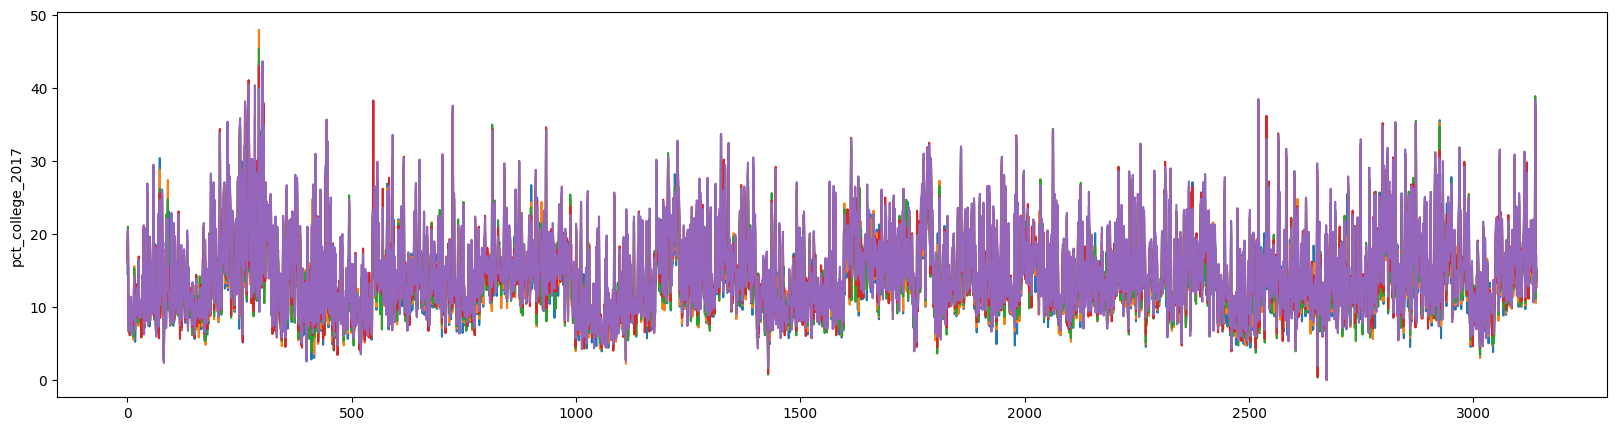

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in ["pct_college_2017" , "pct_college_2018" , "pct_college_2019" , "pct_college_2020" , "pct_college_2021"]:
    sns.lineplot(census[i] , ax = ax)
    

We do the same with this graph, as it is very crowded

In [18]:
x = np.empty(157)
y = np.empty((5 , 157))
for l , j in enumerate(["pct_college_2017" , "pct_college_2018" , "pct_college_2019" , "pct_college_2020" , "pct_college_2021"]):
    for i , k  in enumerate(torch.as_strided(torch.tensor(census[j][:3140])  , (157,20) , (20 ,1))):
        x[i] = torch.mean(k)
    y[l] = x

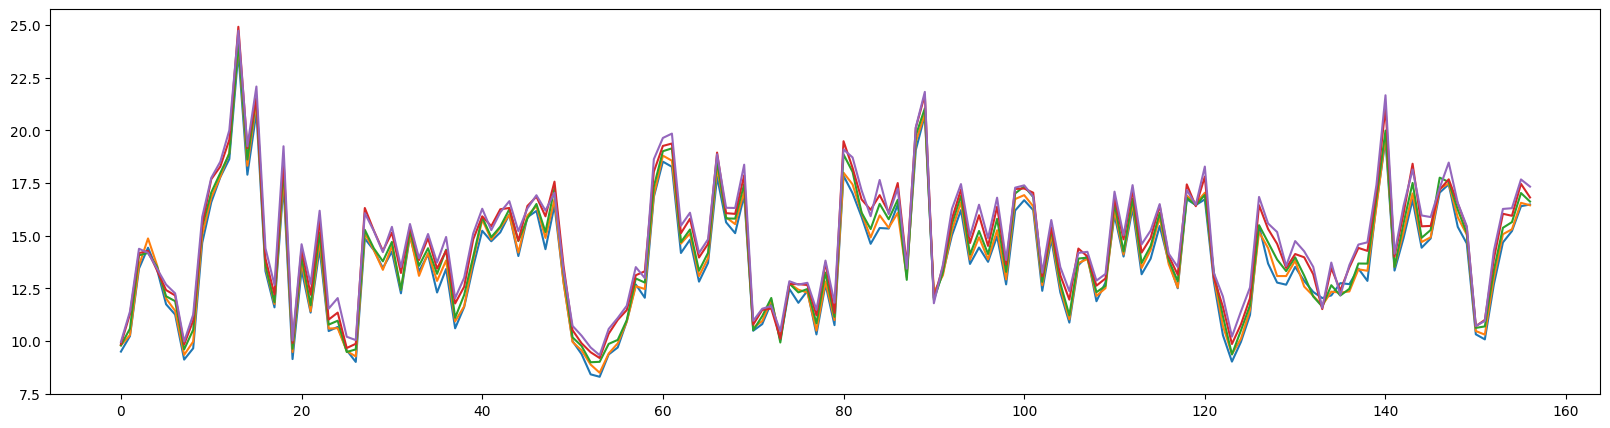

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in range(5):
    sns.lineplot(y[i] , ax = ax)
    

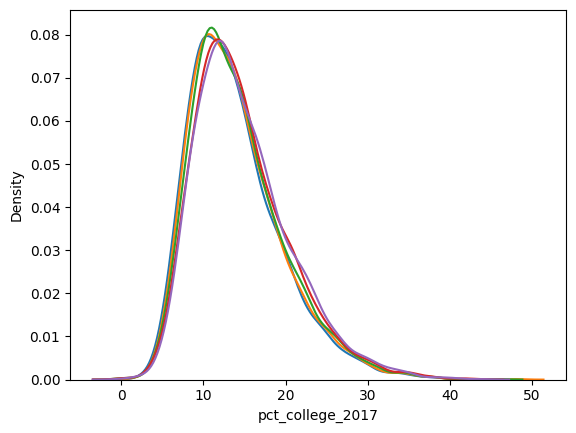

In [20]:
for i in ["pct_college_2017" , "pct_college_2018" , "pct_college_2019" , "pct_college_2020" , "pct_college_2021"]:
    sns.kdeplot(census[i])

We can see that on both the graphs, this value kind of remains the same

## PCT Foriegn Born


There is a positive correlation between the percent of the population in the county born outside of the United States and the micro business density of the country. This means that counties with a higher percentage of foreign-born residents tend to have a higher density of micro businesses.

* Entrepreneurs.  - Willing to take risks and start their own businesses.
* Foreign-born residents bring with them new ideas and perspectives, which can lead to the creation of new businesses.
* Strong ties to their communities, which can help to support the growth of micro businesses.

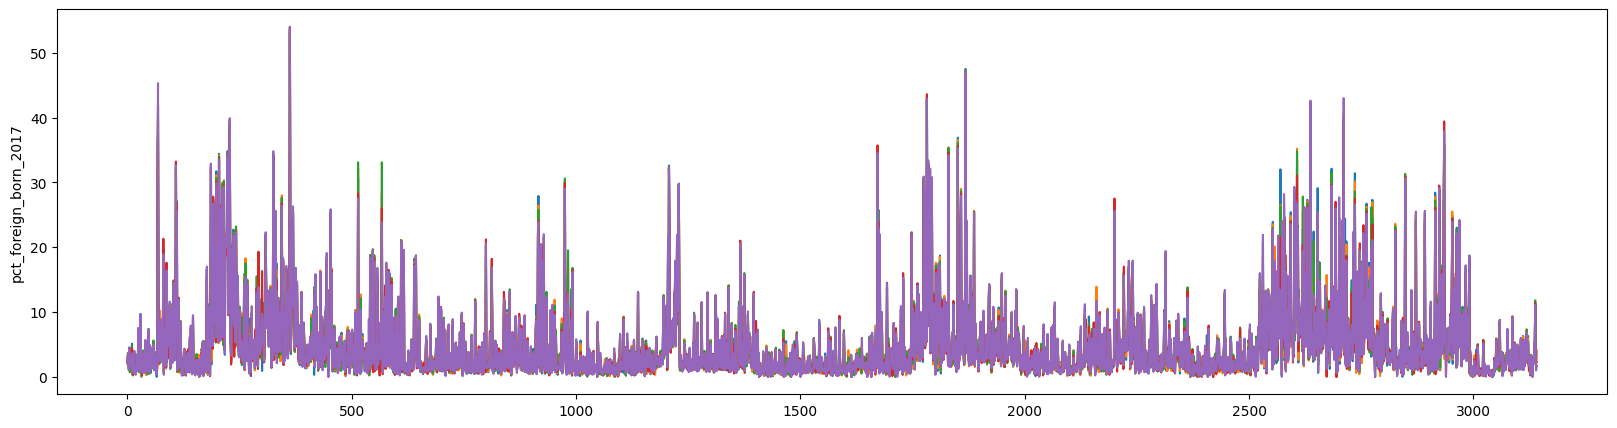

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in ["pct_foreign_born_2017" , "pct_foreign_born_2018" , "pct_foreign_born_2019" , "pct_foreign_born_2020" , "pct_foreign_born_2021"]:
    sns.lineplot(census[i] , ax = ax)
    

In [22]:
x = np.empty(157)
y = np.empty((5 , 157))
for l , j in enumerate(["pct_foreign_born_2017" , "pct_foreign_born_2018" , "pct_foreign_born_2019" , "pct_foreign_born_2020" , "pct_foreign_born_2021"]):
    for i , k  in enumerate(torch.as_strided(torch.tensor(census[j][:3140])  , (157,20) , (20 ,1))):
        x[i] = torch.mean(k)
    y[l] = x

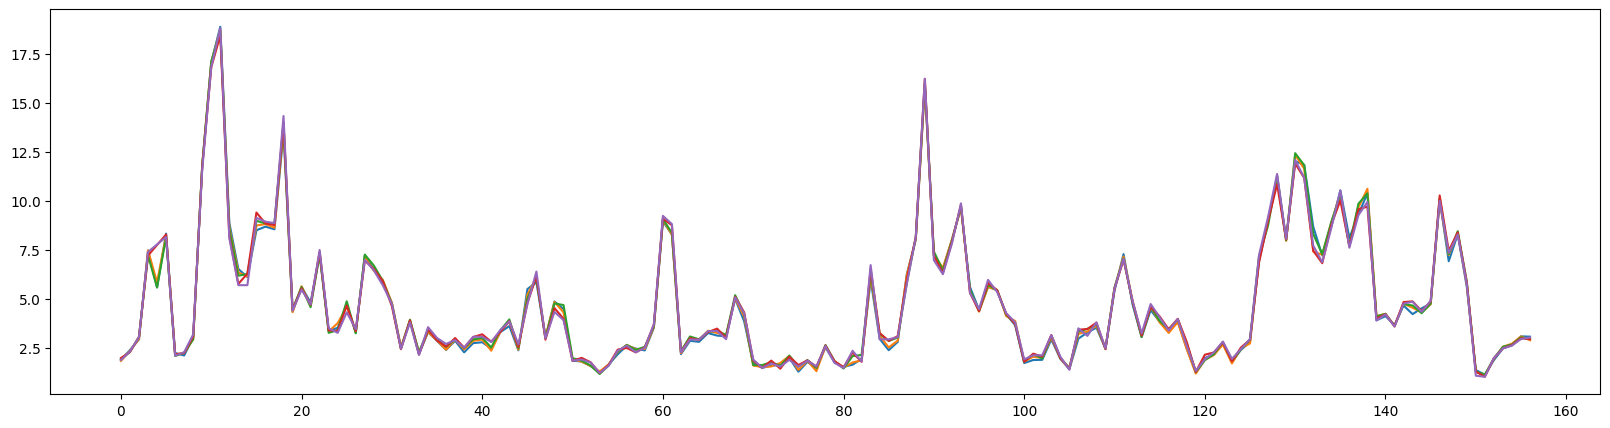

In [23]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in range(5):
    sns.lineplot(y[i] , ax = ax)
    

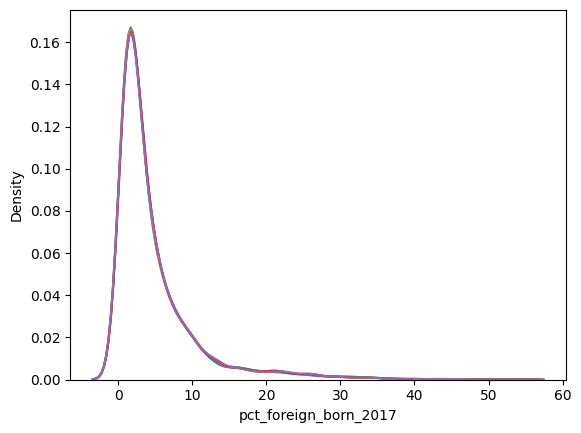

In [24]:
for i in ["pct_foreign_born_2017" , "pct_foreign_born_2018" , "pct_foreign_born_2019" , "pct_foreign_born_2020" , "pct_foreign_born_2021"]:
    sns.kdeplot(census[i])

The data is similar, but is highly skewed twwards the right, it might need `FunctionTransformer`

## Pct It Workers


The percent of the workforce in the county employed in information related industries has a positive impact on the micro business density of the country. This is because information related industries tend to be more entrepreneurial and innovative, which creates an environment that is conducive to the growth of micro businesses.

Information related industries include businesses that provide information products and services, such as software, telecommunications, and media. These industries are characterized by rapid innovation and change, which creates an environment where new businesses can thrive. In addition, information related industries tend to be more entrepreneurial than other industries, as they require a high level of creativity and risk-taking. This entrepreneurial spirit is a major driver of micro business growth.

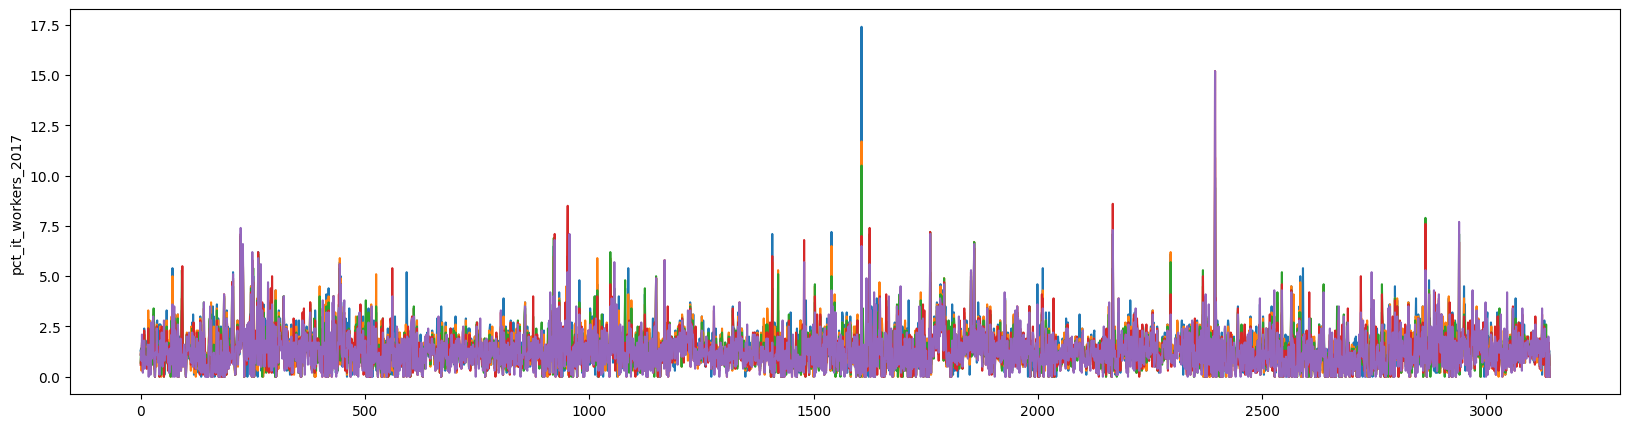

In [25]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in ["pct_it_workers_2017" , "pct_it_workers_2018" , "pct_it_workers_2019" , "pct_it_workers_2020" , "pct_it_workers_2021"]:
    sns.lineplot(census[i] , ax = ax)
    

In [26]:
x = np.empty(157)
y = np.empty((5 , 157))
for l , j in enumerate(["pct_it_workers_2017" , "pct_it_workers_2018" , "pct_it_workers_2019" , "pct_it_workers_2020" , "pct_it_workers_2021"]):
    for i , k  in enumerate(torch.as_strided(torch.tensor(census[j][:3140])  , (157,20) , (20 ,1))):
        x[i] = torch.mean(k)
    y[l] = x

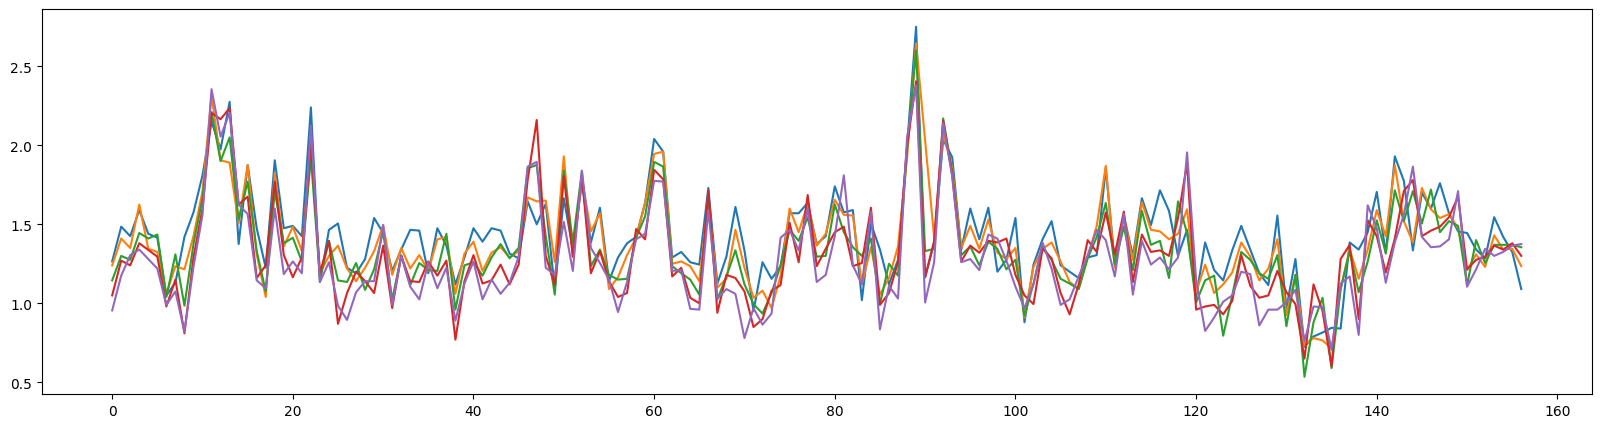

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in range(5):
    sns.lineplot(y[i] , ax = ax)
    

As we can see here only, the data is highly varried with the year

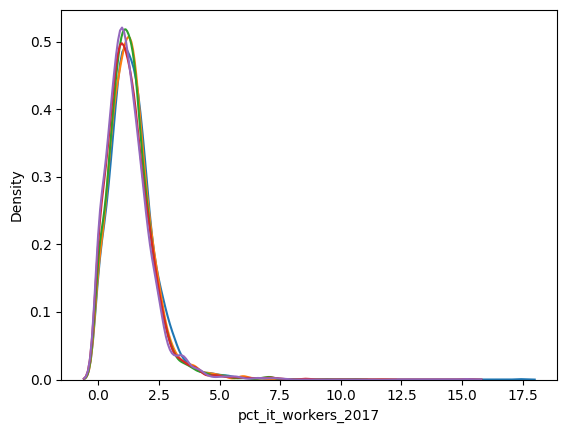

In [28]:
for i in ["pct_it_workers_2017" , "pct_it_workers_2018" , "pct_it_workers_2019" , "pct_it_workers_2020" , "pct_it_workers_2021"]:
    sns.kdeplot(census[i])

The data is highly skewed twwards the right, it might need `FunctionTransformer`

## Median Hh Inc

There is a positive correlation between median household income and micro business density. This means that counties with higher median household incomes tend to have higher micro business densities.

* Higher incomes have more disposable income, which they can use to start or invest in micro businesses
* People with higher incomes are more likely to have the skills and resources needed to start and run a successful micro business. 
* People with higher incomes are more likely to live in areas with supportive environments for micro businesses, such as access to capital, markets, and mentors.

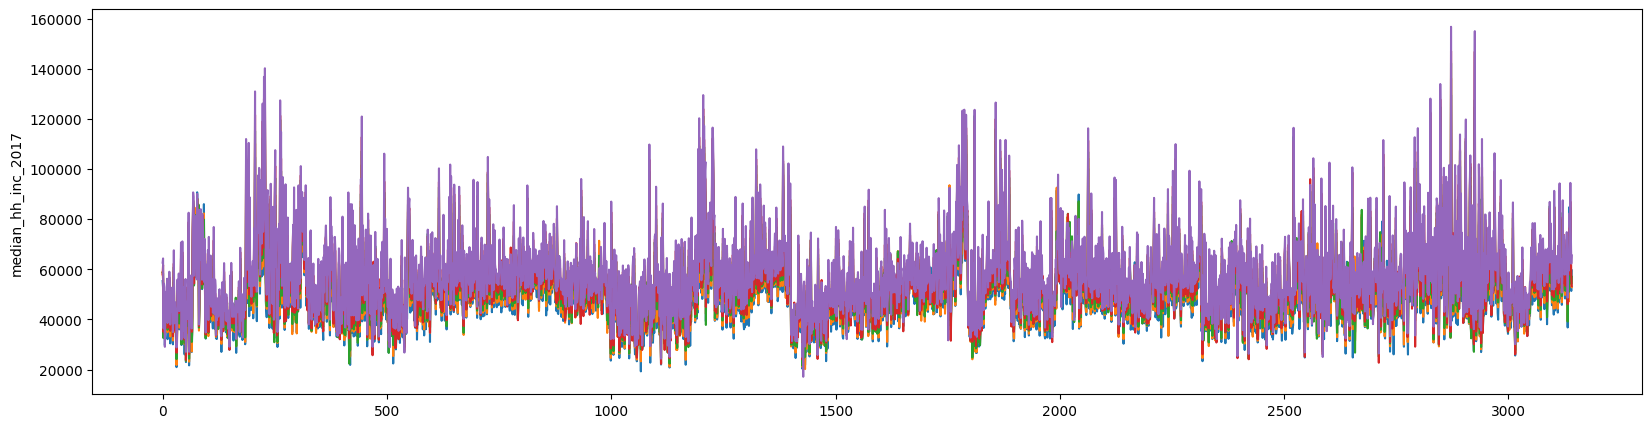

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in ["median_hh_inc_2017" , "median_hh_inc_2018" , "median_hh_inc_2019" , "median_hh_inc_2020" , "median_hh_inc_2021"]:
    sns.lineplot(census[i] , ax = ax)

In [30]:
x = np.empty(157)
y = np.empty((5 , 157))
for l , j in enumerate(["median_hh_inc_2017" , "median_hh_inc_2018" , "median_hh_inc_2019" , "median_hh_inc_2020" , "median_hh_inc_2021"]):
    for i , k  in enumerate(torch.as_strided(torch.tensor(census[j][:3140] , dtype = torch.float32)  , (157,20) , (20 ,1))):
        x[i] = torch.mean(k)
    y[l] = x

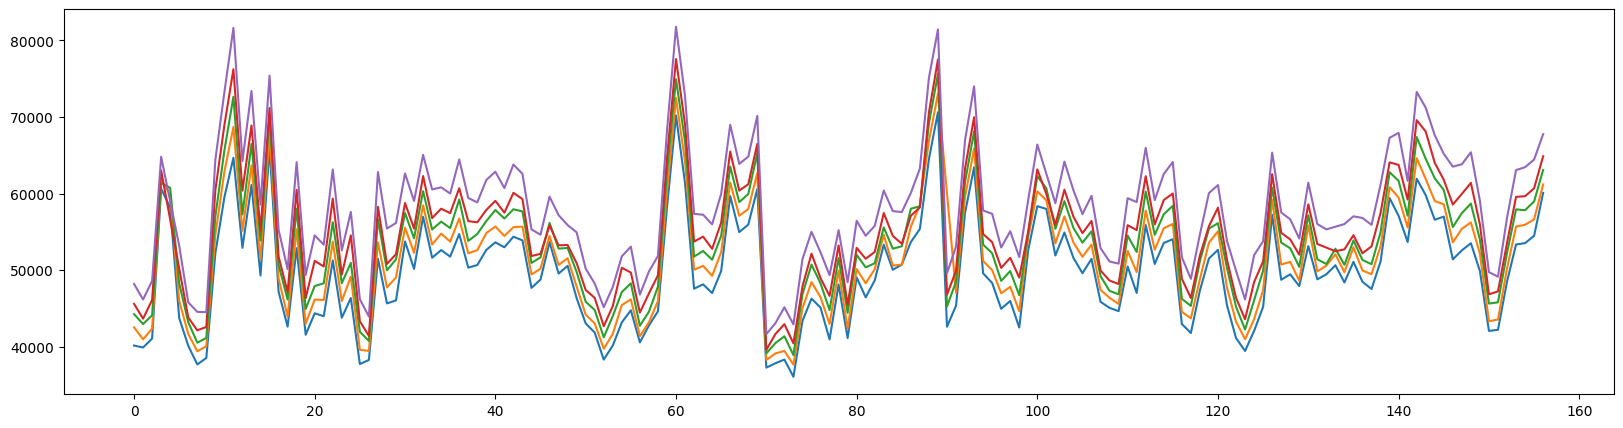

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))

for i in range(5):
    sns.lineplot(y[i] , ax = ax)
    

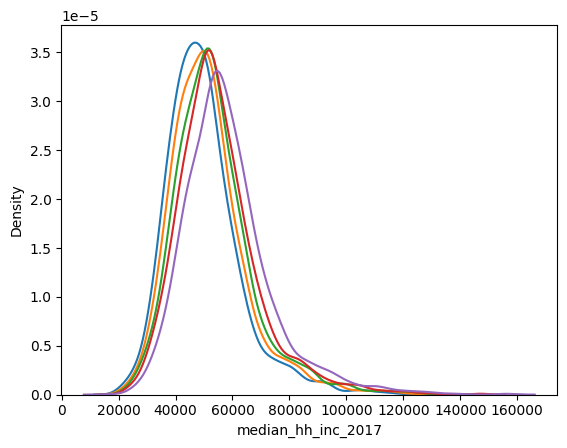

In [32]:
for i in ["median_hh_inc_2017" , "median_hh_inc_2018" , "median_hh_inc_2019" , "median_hh_inc_2020" , "median_hh_inc_2021"]:
    sns.kdeplot(census[i])

This data is higly informative, as it is varied. Though we need to transform it a little bit

# 4 | TO DO LIST 📎
```
# TO DO 1 : TRAIN MACHINE LEARNING MODEL

# TO DO 2 : PREPROCESS THE DATA

# TO DO 3 : IMPROVE VISUALIZATIONS

# TO DO 4 : ADD MORE VISUALIZATIONS

# TO DO 5 : TRAIN NEURAL NETWORK

# TO DO 6 : ADD TQDM SUPPORT

# TO DO 7 : ADD WANDB SUPPORT

# TO DO 8 : IMPROVE ACCURACY 

# TO DO 9 : IMPROVE TRAINING TIME

# TO DO 10 : ADD MEMES

# TO DO 11 : DNACE :)
```

# 5 | Ending 🥳🎊

**THAT IT FOR TODAY GUYS**

**WE WILL GO DEEPER INTO THE DATA IN THE UPCOMING VERSIONS**

**PLEASE COMMENT YOUR THOUGHTS, HIHGLY APPRICIATED**

**DONT FORGET TO MAKE AN UPVOTE, IF YOU LIKED MY WORK :)**

<img src = "https://i.imgflip.com/19aadg.jpg">

**PEACE OUT !!!**